# 0.0. IMPORTS

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import Image

import datetime

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw , how='left', on='Store' )

# 1.0. DESCRICAO DOS DADOS 

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
700851,302,5,2013-10-11,4413,340,1,1,0,0,d,c,2190.0,12.0,2007.0,1,9.0,2011.0,"Mar,Jun,Sept,Dec"


In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Numero de colunas: {}'.format(df1.shape[0]))
print('Numero de colunas: {}'.format(df1.shape[1]))

Numero de colunas: 1017209
Numero de colunas: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance         
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 


#promo interval
month_map = {1: 'Jan',2:'Fev',3:'Mar',4:'Abr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set', 10:'Out',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [12]:
#df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
#df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['competition_open_since_month'] = np.dtype('int64').type(df1['competition_open_since_month'])
df1['competition_open_since_year'] = np.dtype('int64').type(df1['competition_open_since_year'])


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)



## 1.7. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

## 1.7.1 Numerical Attributes

In [14]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

In [15]:
#Concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d5,d6]).T.reset_index()


In [16]:
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']

In [18]:
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

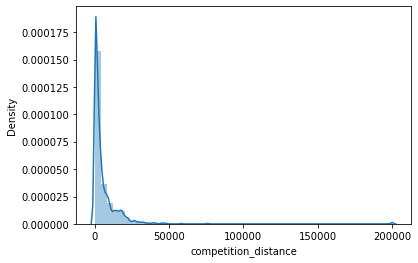

In [19]:
sns.distplot(df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [20]:
#Conteo de valores únicos por cada attributo
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

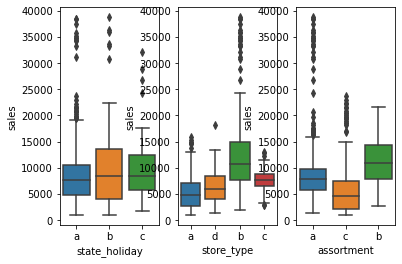

In [21]:
aux1=df1[(df1['state_holiday']!='0') & (df1['sales']>0)]
#a = feriado, b = Feriado de Páscoa, c = Natal

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

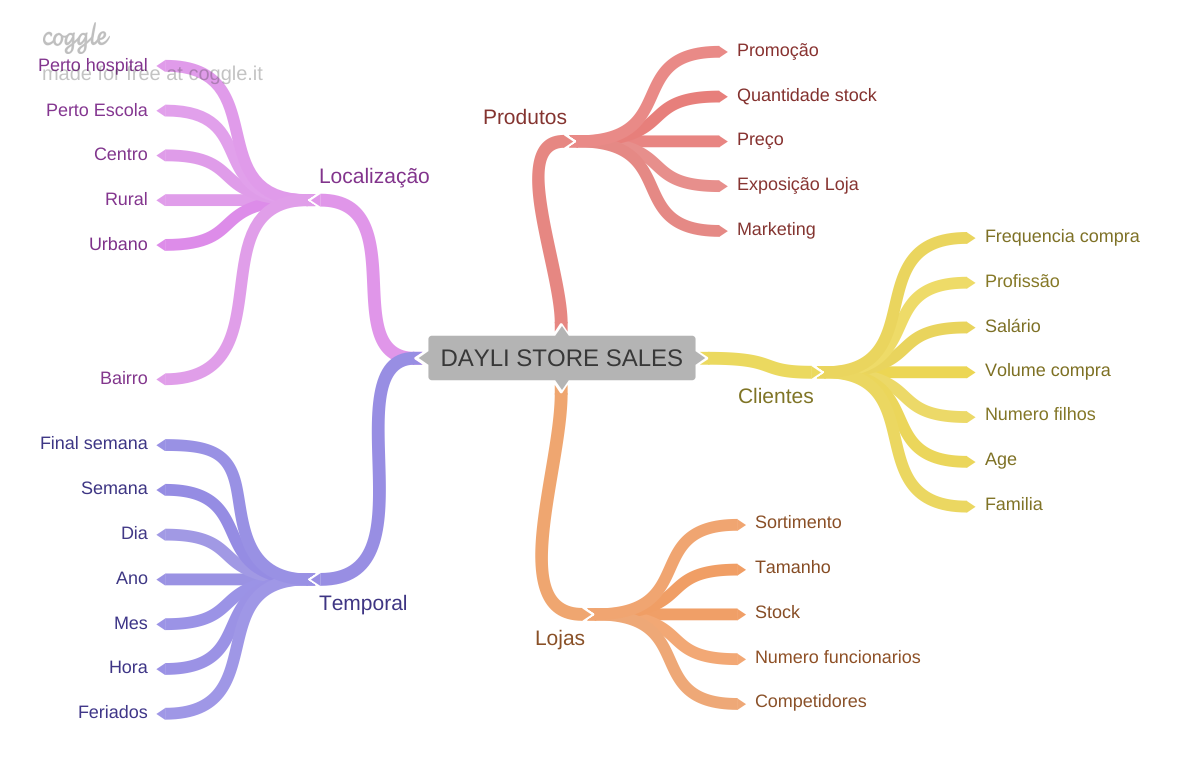

In [23]:
Image('img/DAYLI_STORE_SALES.png')

## 2.1.1. Hipoteses Lojas

**1.** Lojas com maior número de funcionários deveriam vender mais <br>
**2.** Lojas com maior capacidade de estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais perto deveriam vender menos <br>
**6.** Lojas com competidores a mais tempo deveriam vender mais

## 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas com maior exposição de produtos deveriam vender mais <br>
**3.** Lojas com produtos com preço menor deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções consecutivas deveriam vender mais

## 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deverian vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos nos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais perto deveriam vender menos <br>
**3.** Lojas com competidores a mais tempo deveriam vender mais <br>
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções consecutivas deveriam vender mais<br>
**7.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deverian vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos nos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [24]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#promo since
df2['promo_since']=df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

#competition since
#df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1))
#df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holidays
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
